In [2]:
using DrWatson
@quickactivate :NARMAXExperiments


In [3]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using FFTW
using Parameters
import ProgressMeter
using CSV
using DataFrames
gr()

Plots.GRBackend()

In [4]:
import ReactiveMP.messageout

## Generate signal

In [5]:
# find order
seed = 42

delay_y, delay_u, delay_e = 3, 3, 3
order_u = delay_u + 1 # u_k, u_{k-1}, u_{k-2}

poly_order = 2

options = Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false)
syn_input, syn_noise, syn_output, η_true = generate_data(seed, ϕ, options, w_true=1e1, scale_coef=0.2);

full_order = length(ϕ(zeros(delay_y+delay_e+order_u), options))

42

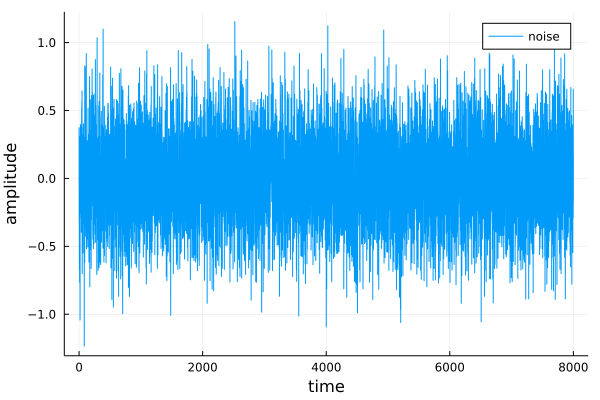

In [6]:
# Visualize noise
plot(syn_noise, xlabel="time", ylabel="amplitude", label="noise")

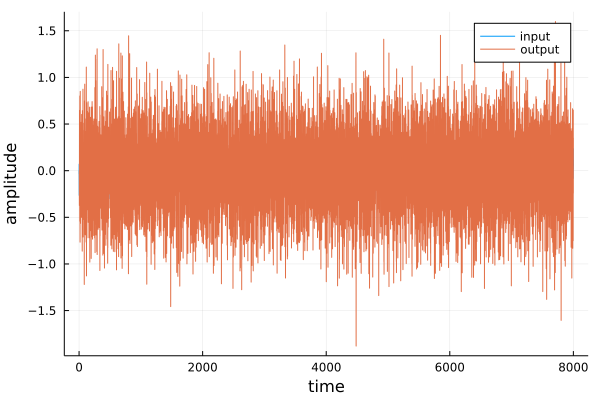

In [7]:
# Plot both input and outputs
plot(syn_input, label="input")
plot!(syn_output, xlabel="time", ylabel="amplitude", label="output")

In [8]:
train_size = 1000+order_u
test_size = 1000+order_u

u_train = syn_input[1:train_size]
u_val = syn_input[train_size + 1:train_size + test_size]
y_train = syn_output[1:train_size]
y_val = syn_output[train_size + 1:train_size + test_size]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

# output_trn = y_train
# output_val = y_val
# input_trn = u_train
# input_val = u_val

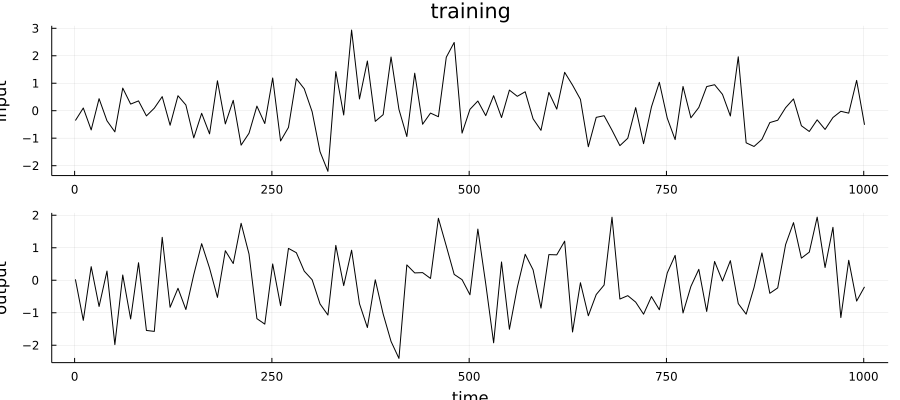

In [9]:
# Plot every n-th time-point to avoid figure size exploding
n = 10
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

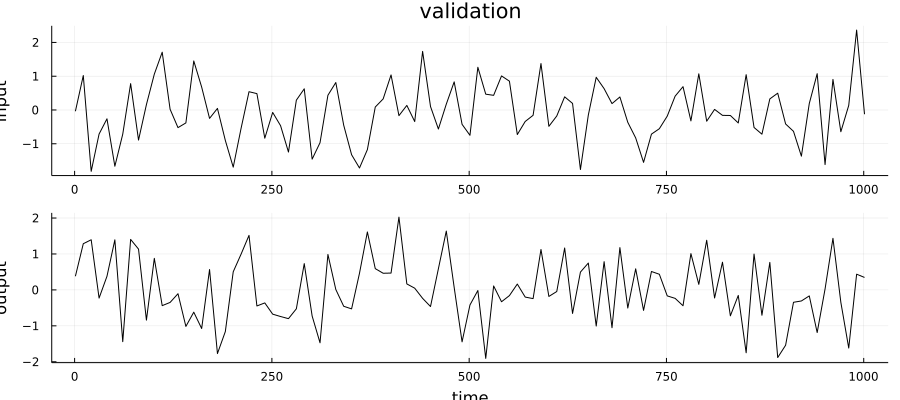

In [10]:
n = 10
ix = 1:n:length(output_val)

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

### prepare training/test sets 

In [11]:
# Generate training data
observations_prev, observations = ssm(output_trn, delay_y)
controls = ssm(input_trn, order_u)[1]
X_train, Y_train, U_train = observations_prev[1:train_size-order_u], observations[1:train_size-order_u], controls[1:train_size-order_u];

# Generate validation data
observations_prev, observations = ssm(output_val, delay_y)
controls = ssm(input_val, order_u)[1]
X_test, Y_test, U_test = observations_prev[1:test_size-order_u], observations[1:test_size-order_u], controls[1:test_size-order_u];

In [12]:
function phi()
    options = Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false)
    
    precompiled = precompiled_phi(options)
    
    return (u, y, h) -> begin
        na = length(y)
        nb = length(u)-1
        ne = length(h)-1
        precompiled([u; y; h[1:end]])
    end 
end

const phi_ = phi()

#1 (generic function with 1 method)

In [13]:
# Nonlinear MAX model definition
@model function narmax(n, h_prior, w_prior, η_prior, τ_prior, y_prev, u, delay_e, order)
        
    S = shift(delay_e); c = zeros(delay_e); c[1] = 1.0;
    
    # initialize variables
    w  = randomvar()
    h  = randomvar(n-1)
    e  = randomvar(n)
    z  = randomvar(n)
    ẑ  = randomvar(n)
    y  = datavar(Float64, n)
        
    # priors
    w  ~ GammaShapeRate(w_prior[1], w_prior[2])
    η  ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ  ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    # initial
    h_0  ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    z[1] ~ NonlinearNode(h_0) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e))), meta = NonlinearMeta(UT(), phi_, y_prev[1], u[1])}
    ẑ[1] ~ AR(z[1], η, τ)
    
    b = zeros(order); b[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n-1
        
        e[t] ~ NormalMeanPrecision(0.0, w)
        h[t] ~ S*h_prev + c*e[t]
        y[t] ~ dot(ẑ[t], b) + e[t]
    
        h_prev = h[t]
        z[t+1] ~ NonlinearNode(h_prev) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e))), meta = NonlinearMeta(UT(), phi_, y_prev[t+1], u[t+1])}
        ẑ[t+1] ~ AR(z[t+1], η, τ)
    end
    
    e[n] ~ NormalMeanPrecision(0.0, w)
    y[n] ~ dot(ẑ[n], b) + e[n]

    return w, h, η, τ, z, ẑ, y
end

In [14]:

coefs_mean = zeros(full_order);
coefs_precision = diageye(full_order);


In [15]:
h_prior, w_prior, η_prior, τ_prior = MvNormalMeanPrecision(zeros(delay_e), 1e-1diageye(delay_e)), GammaShapeRate(1e3, 1.0), MvNormalMeanPrecision(coefs_mean, coefs_precision),  GammaShapeRate(1e2, 1.0)

(MvNormalMeanPrecision(
μ: [0.0, 0.0, 0.0]
Λ: [0.1 0.0 0.0; 0.0 0.1 0.0; 0.0 0.0 0.1]
)
, GammaShapeRate{Float64}(a=1000.0, b=1.0), MvNormalMeanPrecision(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Λ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)
, GammaShapeRate{Float64}(a=100.0, b=1.0))

In [275]:
# ##Non-linear node rules UKF 

# const default_alpha = 1e-3 # Default value for the spread parameter
# const default_beta = 2.0
# const default_kappa = 0.0


# ##Return the sigma points and weights for a Gaussian distribution

# function sigmaPointsAndWeights(m::Vector{Float64}, V::AbstractMatrix; alpha=default_alpha, beta=default_beta, kappa=default_kappa)
#     d = length(m)
#     lambda = (d + kappa)*alpha^2 - d

#     sigma_points = Vector{Vector{Float64}}(undef, 2*d+1)
#     weights_m = Vector{Float64}(undef, 2*d+1)
#     weights_c = Vector{Float64}(undef, 2*d+1)

#     if isa(V, Diagonal)
#         L = sqrt((d + lambda)*V) # Matrix square root
#     else
#         L = sqrt(Hermitian((d + lambda)*V))
#     end

#     sigma_points[1] = m
#     weights_m[1] = lambda/(d + lambda)
#     weights_c[1] = weights_m[1] + (1 - alpha^2 + beta)
#     for i = 1:d
#         sigma_points[2*i] = m + L[:,i]
#         sigma_points[2*i+1] = m - L[:,i]
#     end
#     weights_m[2:end] .= 1/(2*(d + lambda))
#     weights_c[2:end] .= 1/(2*(d + lambda))

#     return (sigma_points, weights_m, weights_c)
# end

# function unscentedStatistics(m::Vector{Float64}, V::AbstractMatrix, g::Function; alpha=default_alpha, beta=default_beta, kappa=default_kappa)
#     (sigma_points, weights_m, weights_c) = sigmaPointsAndWeights(m, V; alpha=alpha, beta=beta, kappa=kappa)
#     d = length(m)

#     g_sigma = g.(sigma_points)
#     m_tilde = sum([weights_m[k+1]*g_sigma[k+1] for k=0:2*d])
#     V_tilde = sum([weights_c[k+1]*(g_sigma[k+1] - m_tilde)*(g_sigma[k+1] - m_tilde)' for k=0:2*d])
#     C_tilde = sum([weights_c[k+1]*(sigma_points[k+1] - m)*(g_sigma[k+1] - m_tilde)' for k=0:2*d])

#     return (m_tilde, V_tilde, C_tilde)
# end

# function smoothRTSMessage(m_tilde, V_tilde, C_tilde, m_fw_in, V_fw_in, m_bw_out, V_bw_out)
#     C_tilde_inv = pinv(C_tilde)
#     V_bw_in = V_fw_in*C_tilde_inv'*(V_tilde + V_bw_out)*C_tilde_inv*V_fw_in - V_fw_in
#     m_bw_in = m_fw_in + V_fw_in*C_tilde_inv'*(m_bw_out - m_tilde)

#     return (m_bw_in, V_bw_in) # Statistics for backward message on in
# end

# """
# RTS smoother update for inbound marginal; based on (Petersen et al. 2018; On Approximate Nonlinear Gaussian Message Passing on Factor Graphs)
# """
# function smoothRTS(m_tilde, V_tilde, C_tilde, m_fw_in, V_fw_in, m_bw_out, V_bw_out)
#     P = cholinv(V_tilde + V_bw_out)
#     W_tilde = cholinv(V_tilde)
#     D_tilde = C_tilde*W_tilde
#     V_in = V_fw_in + D_tilde*(V_bw_out*P*C_tilde' - C_tilde')
#     m_out = V_tilde*P*m_bw_out + V_bw_out*P*m_tilde
#     m_in = m_fw_in + D_tilde*(m_out - m_tilde)

#     return (m_in, V_in) # Statistics for marginal on in
# end


# @rule NonlinearNode(:out, Marginalisation) (m_in::NormalDistributionsFamily, meta::NonlinearMeta) = begin
#     def_fn(s) = meta.fn(meta.us, meta.ysprev, s)
#     (m_fw_in1, V_fw_in1) = mean_cov(m_in)
#     (m_tilde, V_tilde, _) = unscentedStatistics(m_fw_in1, V_fw_in1, def_fn; alpha=default_alpha)
#     return MvNormalMeanCovariance(m_tilde,V_tilde)
# end


# @rule NonlinearNode(:in, Marginalisation) (m_out::NormalDistributionsFamily, m_in::NormalDistributionsFamily, meta::NonlinearMeta) = begin
#     def_fn(s) = meta.fn(meta.us, meta.ysprev, s)
#     (m_fw_in1, V_fw_in1) = mean_cov(m_in)
#     (m_tilde, V_tilde, C_tilde) = unscentedStatistics(m_fw_in1, V_fw_in1, def_fn; alpha=default_alpha)

#     # RTS smoother
#     (m_bw_out, V_bw_out) = mean_cov(m_out)
#     (m_bw_in1, V_bw_in1) = smoothRTSMessage(m_tilde, V_tilde, C_tilde, m_fw_in1, V_fw_in1, m_bw_out, V_bw_out)
#     return MvNormalMeanCovariance(m_bw_in1, V_bw_in1)
# end


In [276]:
narmax_imarginals = (h = h_prior,
                     w = w_prior,
                     τ = τ_prior,
                     η = η_prior,
                     e = NormalMeanPrecision(0.0, 1.0));

In [277]:
narmax_imessages = (e = NormalMeanPrecision(0.0, 1e-10), );

In [278]:
@meta function narmax_meta(artype, order, stype)
    AR(ẑ, η, τ) -> ARMeta(artype, order, stype)
end

narmax_meta (generic function with 1 method)

In [279]:
narmax_constraints = @constraints begin
    q(ẑ, z, η, τ, e, w, h, h_0) = q(ẑ, z, h, h_0)q(η)q(τ)q(e)q(w)
end;

In [280]:
narmax_model = Model(narmax, length(Y_train), 
                    (mean(h_prior), precision(h_prior)), 
                    (shape(w_prior), rate(w_prior)), 
                    (mean(η_prior), precision(η_prior)), 
                    (shape(τ_prior), rate(τ_prior)), 
                    X_train, U_train, delay_e, full_order);

In [281]:
# First execution is slow due to Julia's init compilation 
result = inference(
    model = narmax_model, 
    data  = (y = Y_train, ),
    constraints   = narmax_constraints,
    meta          = narmax_meta(Multivariate, full_order, ARsafe()),
    options       = model_options(limit_stack_depth = 500),
    initmarginals = narmax_imarginals,
    initmessages  = narmax_imessages,
    returnvars    = (w=KeepLast(), h=KeepLast(), η=KeepLast(), τ=KeepLast(), z=KeepLast(), ẑ=KeepLast()),
    free_energy   = true,
    iterations    = 20, 
    showprogress  = true
);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


In [290]:
fe = result.free_energy

20-element Vector{Real}:
  5660.77115634724
  3433.1522808678146
  2203.4657212520797
  1103.4913284441718
   316.1846949153114
  -156.9723998126574
  -424.724908245742
  -570.3896464698919
  -657.8935970407183
  -721.1852982481796
  -774.6483376643737
  -823.9422004256485
  -871.2667509374587
  -917.3397443611611
  -963.3007124976721
 -1009.1623633612908
 -1054.9249034240638
 -1101.0390771702369
 -1147.972544341057
 -1194.9815328703116

In [291]:
using Parameters
@unpack w, h, η, τ, z, ẑ = result.posteriors

Dict{Symbol, Any} with 6 entries:
  :w => Marginal(GammaShapeRate{Float64}(a=1500.0, b=1.4997149147126176))
  :ẑ => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :τ => Marginal(GammaShapeRate{Float64}(a=600.0, b=80.2659429186194))
  :h => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :z => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :η => Marginal(MvNormalWeightedMeanPrecision(…

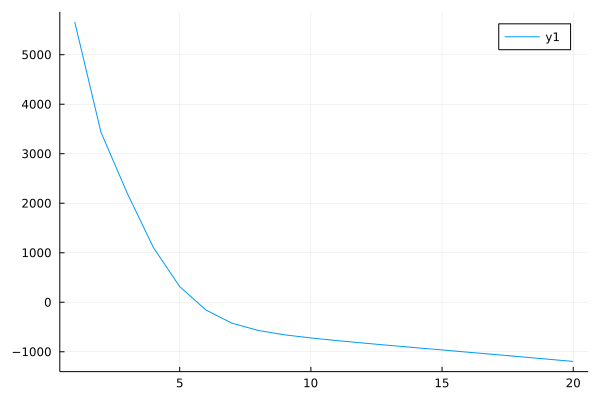

In [292]:
gr()
plot(fe[1:end])

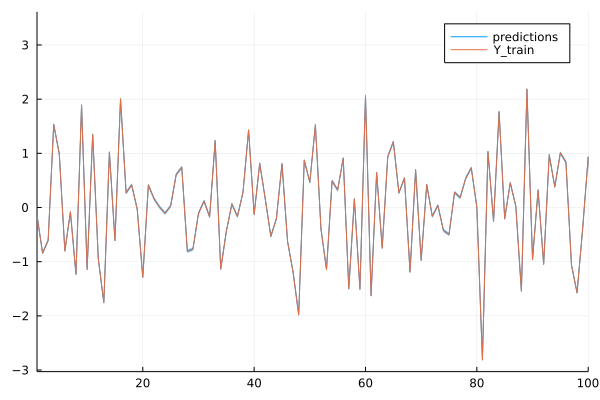

In [293]:
mfrom, mto = 1, 100
plot(first.(mean.(ẑ)), ribbon=first.(sqrt.(cov.(ẑ))), label="predictions")
plot!(Y_train, xlims=(mfrom, mto), label="Y_train")

In [294]:
mean(w)

1000.1900929867307

In [295]:
mean(τ)

7.475150458374758

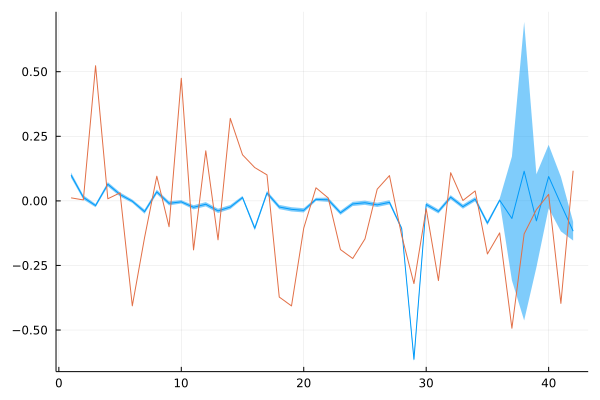

In [296]:
plot(mean(η), ribbon=diag(std(η)), label=false)
plot!(η_true, label=false)

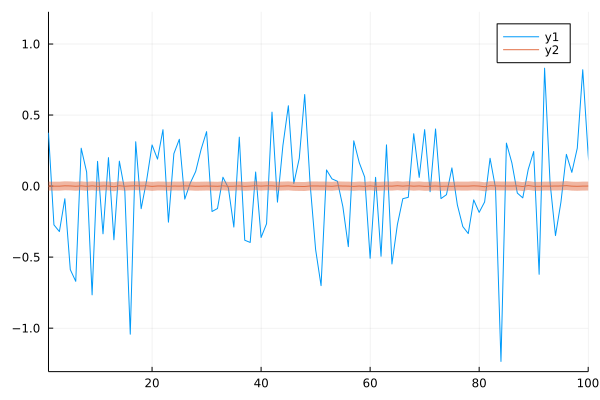

In [297]:
gr()
plot(syn_noise)
plot!(first.(mean.(h)), ribbon=sqrt.(first.(cov.(h))), xlims=(1, 100))

## Prediction 

In [298]:
function prediction(h_prior, w_mle, η_posterior, τ_posterior, y_prev, u; full_order)
    h_out = MvNormalMeanPrecision(mean(h_prior), precision(h_prior))
    ϕ_out = @call_rule NonlinearNode(:out, Marginalisation) (m_in=h_out, meta=NonlinearMeta(UT(), phi_, y_prev, u))
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=ϕ_out, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, full_order, ARsafe()))
    c = zeros(full_order); c[1] = 1.0
    dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())

    e_out = @call_rule NormalMeanPrecision(:out, Marginalisation) (m_μ=PointMass(0.0), m_τ=PointMass(w_mle))
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=dot_out, m_in2=e_out)  
end

prediction (generic function with 1 method)

In [299]:
# Nonlinear MAX model definition
@model function narmax_mini(h_prior, w_prior, η_prior, τ_prior, y_prev, u, delay_e, order)
        
    # initialize variables
    y  = datavar(Float64)
    # priors
    w  ~ GammaShapeRate(shape(w_prior), rate(w_prior))
    η  ~ MvNormalMeanPrecision(mean(η_prior), precision(η_prior))
    τ  ~ GammaShapeRate(shape(τ_prior), rate(τ_prior))
    # initial
    h_0  ~ MvNormalMeanPrecision(mean(h_prior), precision(h_prior))
    z ~ NonlinearNode(h_0) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e))), meta = NonlinearMeta(UT(), phi_, y_prev, u)}
    ẑ ~ AR(z, η, τ)
    e ~ NormalMeanPrecision(0.0, w)
    b = zeros(order); b[1] = 1.0;
    y ~ dot(b, ẑ) + e

    return
end

In [300]:
function inference_callback(h_prior, η_prior, τ_prior, w_prior, Y, X, U, delay_e, order)
    
    narmax_mini_model = Model(narmax_mini, h_prior, w_prior, η_prior, τ_prior, X, U, delay_e, full_order)

    mini_constraints = @constraints begin
        q(ẑ, z, η, τ, e, w, h_0) = q(ẑ, z, h_0)q(η)q(τ)q(e)q(w)
    end;

    mini_imarginals = (h_0 = h_prior,
                       w = w_prior,
                       τ = τ_prior,
                       η = η_prior);

    mini_result = inference(
                    model = narmax_mini_model, 
                    data  = (y = Y, ),
                    constraints   = mini_constraints,
                    meta          = narmax_meta(Multivariate, full_order, ARsafe()),
                    initmarginals = mini_imarginals, 
                    returnvars    = (w=KeepLast(), e=KeepLast(), η=KeepLast(), τ=KeepLast(), z=KeepLast(), ẑ=KeepLast(), h_0=KeepLast()),
                    free_energy   = true,
                    iterations    = 10, 
                    showprogress  = true
                );
    @unpack w, e, η, τ, z, ẑ, h_0 = mini_result.posteriors
    w.data, e.data, η.data, τ.data
end

inference_callback (generic function with 1 method)

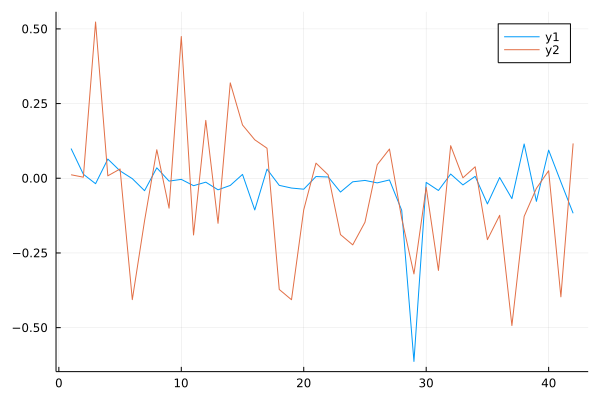

In [301]:
plot(mean(η))
plot!(η_true)

In [302]:
predictions = []
h_prior = h[end].data
w_prior = w.data
τ_prior = τ.data
η_prior = η.data

ProgressMeter.@showprogress for i in 1:length(Y_test)
    pred = prediction(h_prior, mean(w_prior), η_prior, τ_prior, X_test[i], U_test[i], full_order=full_order)
    push!(predictions, pred)
#     w_post, e_post, η_post, τ_post = inference_callback(h_prior, η_prior, τ_prior, w_prior, Y_test[i], X_test[i], U_test[i], delay_e, full_order)
#     h_prior = MvNormalMeanCovariance([mean(e_post); mean(h_prior)[2:end]], Diagonal([cov(e_post); var(h_prior)[2:end]]))
#     η_prior = η_post
#     τ_prior = τ_post
#     w_prior = w_post
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


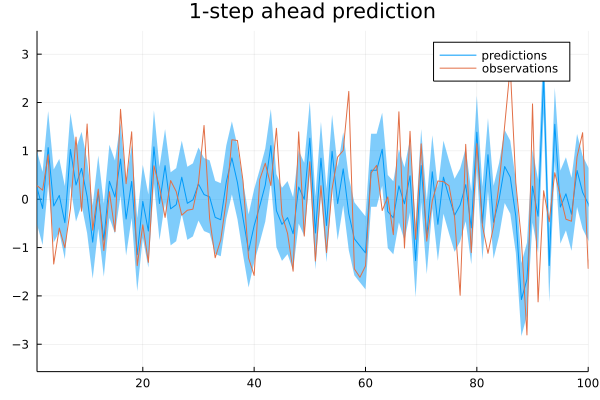

In [303]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_test, xlims=(1, 100), title="1-step ahead prediction", label="observations")

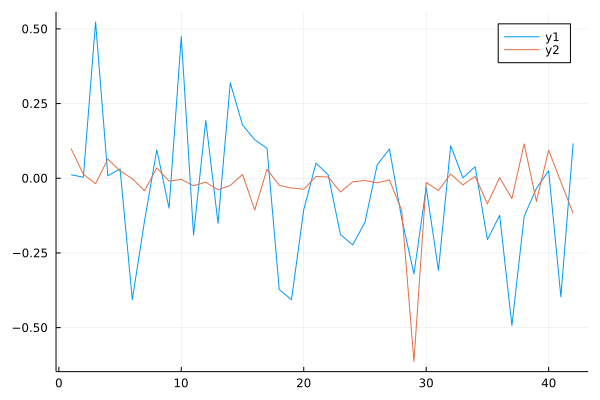

In [304]:
plot(η_true)
plot!(mean(η_prior))


In [305]:
RMSE = sqrt(mean((mean.(predictions) .- Y_test) .^2))

0.8150043823961615

In [254]:
# naive simulation setting

In [306]:
h_prior = h[end].data
w_prior = w.data
τ_prior = τ.data
η_prior = η.data

simulated_X = [X_test[1]]
simulated_Y = [Y_test[1]]
simulated_Y_cov = [0.0]
simulated_error = Vector{Any}([h[end]])

ProgressMeter.@showprogress for i in 1:length(Y_test)

#     w_post, e_post, η_post, τ_post = inference_callback(h_prior, η_prior, τ_prior, w_prior, simulated_Y[i], simulated_X[i], U_test[i], delay_e, full_order)
    
#     h_prior = MvNormalMeanPrecision([mean(e_post); mean(h_prior)[2:end]], Diagonal([cov(e_post); var(h_prior)[2:end]]))
#     η_prior = η_post
#     τ_prior = τ_post
#     w_prior = w_post
    
    push!(simulated_X, [simulated_Y[i]; simulated_X[i][1:delay_y-1]])
    
    pred_sim = prediction(h_prior, mean(w_prior), η_prior, τ_prior, simulated_X[end], U_test[i], full_order=full_order)

    push!(simulated_Y, mean(pred_sim))
    push!(simulated_Y_cov, var(pred_sim))
    push!(simulated_error, h_prior)
    

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [307]:
RMSE = sqrt(mean((simulated_Y[2:end] .- Y_test).^2))

0.9907420266227893

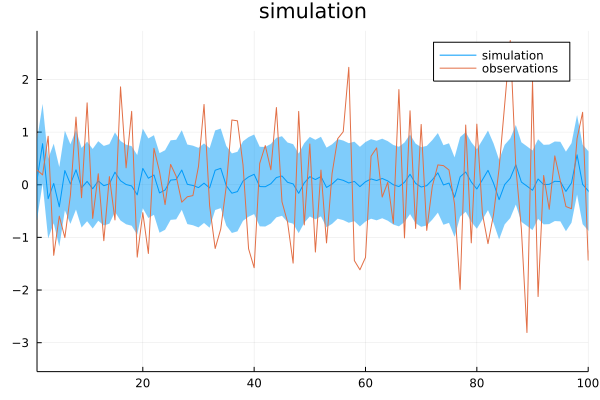

In [308]:
plot(simulated_Y[2:end], ribbon=sqrt.(simulated_Y_cov[2:end]), label="simulation")
# plot!(first.(U_test), label="controls")
plot!(Y_test, title="simulation", label="observations", xlims=(1, 100))

In [258]:
zoom = 1:100
RMSE = sqrt(mean((simulated_Y[zoom .+ 1] .- Y_test[zoom]).^2))

0.45504320610277377

In [169]:
using PGFPlotsX
using LaTeXStrings
pgfplotsx()
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}");

In [170]:
function plot_inference(path, input, output, predicted_out, inferred_h)
    
    predicted_m, predicted_v = predicted_out[1], predicted_out[2]
    inferred_m, inferred_v = inferred_h[1], inferred_h[2]
    
    plt_inference = @pgf GroupPlot(
    # group plot options
    {
        width="15cm", height="7cm",

        group_style = {
            group_size = "1 by 2",
            horizontal_sep = "0.5cm",
        },
    },

    # first
    {
    title="Simulation result",
    ylabel="amplitude",
     legend_pos = "north west",
     legend_cell_align="{left}",
     grid = "major",
     legend_style = "{nodes={scale=1.0, transform shape}}",
     yticklabel_style={
        "/pgf/number format/fixed,
        /pgf/number format/precision=3"
        },
     each_nth_point=skip,
     xtick_distance = 200,
     xmin=0.0, xmax=length(output),
     xticklabels={},
    },
    Plot({no_marks, color="blue!70", style={"ultra thick"}}, Coordinates(collect(1:length(output)), output), LegendEntry("output")),
    
    Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:length(output)), predicted_m)),
    Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:length(output)), predicted_m .+  sqrt.(predicted_v))),
    Plot({"name path=g", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:length(output)), predicted_m .-  sqrt.(predicted_v))),
            
    # second
    {
     xlabel=L"k",
     ylabel="amplitude",
     legend_pos = "north west",
     legend_cell_align="{left}",
     grid = "major",
     legend_style = "{nodes={scale=1.0, transform shape}}",
     yticklabel_style={
        "/pgf/number format/fixed,
        /pgf/number format/precision=3"
        },
     each_nth_point=skip,
     xtick_distance = 200,
     xmin=0.0, xmax=sig_len,
    },
            
    Plot({no_marks, color="blue!70", style={"ultra thick"}}, Coordinates(collect(1:length(output)), output), LegendEntry("output"),
    
    Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:length(output)), inferred_m)),
    Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:length(output)), inferred_m .+  sqrt.(inferred_v))),
    Plot({"name path=g", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:length(output)), inferred_m .-  sqrt.(inferred_v))),
    ))
#     pgfsave(path, plt_inference)
    return plt_inference
end

plot_inference (generic function with 1 method)

In [171]:
function plot_fe(path, FE, vmp_its, start=3, )
    axis4 = @pgf Axis({xlabel="iteration",
                    ylabel="Free Energy [nats]",
                    legend_pos = "north east",
                    legend_cell_align="{left}",
                    scale = 1.0,
                    grid = "major",
                    width="20cm", height="12cm"
        },
    Plot({mark = "o", "red", mark_size=1}, Coordinates(collect(start:vmp_its), FE[start:end])), LegendEntry("FE"))
    pgfsave(path, axis4)
    
end

plot_fe (generic function with 2 methods)

In [172]:
h_mean, h_cov = first.(mean.(simulated_error[2:end])), first.(cov.(simulated_error[2:end]))

([4.546694864467045e-5, 4.546694864467045e-5, 4.546694864467045e-5, 4.546694864467045e-5, 4.546694864467045e-5, 4.546694864467045e-5, 4.546694864467045e-5, 4.546694864467045e-5, 4.546694864467045e-5, 4.546694864467045e-5  …  4.546694864467045e-5, 4.546694864467045e-5, 4.546694864467045e-5, 4.546694864467045e-5, 4.546694864467045e-5, 4.546694864467045e-5, 4.546694864467045e-5, 4.546694864467045e-5, 4.546694864467045e-5, 4.546694864467045e-5], [0.000999877470755159, 0.000999877470755159, 0.000999877470755159, 0.000999877470755159, 0.000999877470755159, 0.000999877470755159, 0.000999877470755159, 0.000999877470755159, 0.000999877470755159, 0.000999877470755159  …  0.000999877470755159, 0.000999877470755159, 0.000999877470755159, 0.000999877470755159, 0.000999877470755159, 0.000999877470755159, 0.000999877470755159, 0.000999877470755159, 0.000999877470755159, 0.000999877470755159])

In [177]:
plot_inference("", input_val[2:end], output_val[2:end], (simulated_Y[2:end], simulated_Y_cov[2:end]), (h_mean, h_cov))

LoadError: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 1003 and 1000")

In [178]:
output = output_val[1:100]
predicted_m, predicted_v = (simulated_Y[2:end], simulated_Y_cov[2:end])
inferred_m, inferred_v = h_mean, h_cov
    
plt_inference = @pgf GroupPlot(
    # group plot options
    {
        width="15cm", height="7cm",

        group_style = {
            group_size = "1 by 2",
            horizontal_sep = "0.5cm",
        },
    },

    # first
    {
     title="Simulation result",
     ylabel="amplitude",
     legend_pos = "north west",
     legend_cell_align="{left}",
     grid = "major",
     legend_style = "{nodes={scale=1.0, transform shape}}",
     yticklabel_style={
        "/pgf/number format/fixed,
        /pgf/number format/precision=3"
        },
     each_nth_point=skip,
     xtick_distance = 200,
     xmin=0.0, xmax=length(output),
     xticklabels={},
    },
    Plot({no_marks, color="blue!70", style={"ultra thick"}}, Coordinates(collect(1:length(output)), output)), LegendEntry("output"),
    
)
#     pgfsave(path, plt_inference)


GroupPlot(PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("width" => "15cm", "height" => "7cm", "group_style" => PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("group_size" => "1 by 2", "horizontal_sep" => "0.5cm"), true)), true), Any[PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("title" => "Simulation result", "ylabel" => "amplitude", "legend_pos" => "north west", "legend_cell_align" => "{left}", "grid" => "major", "legend_style" => "{nodes={scale=1.0, transform shape}}", "yticklabel_style" => PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("/pgf/number format/fixed,\n        /pgf/number format/precision=3" => nothing), true), "each_nth_point" => skip, "xtick_distance" => 200, "xmin" => 0.0…), true), Plot(false, false, PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("no_marks" => nothing, "color" => "blue!70", "style" => PGFPlotsX.Options(OrderedCollections.OrderedDict{Any, Any}("ultra thick" => nothing), true)), true), Coordin

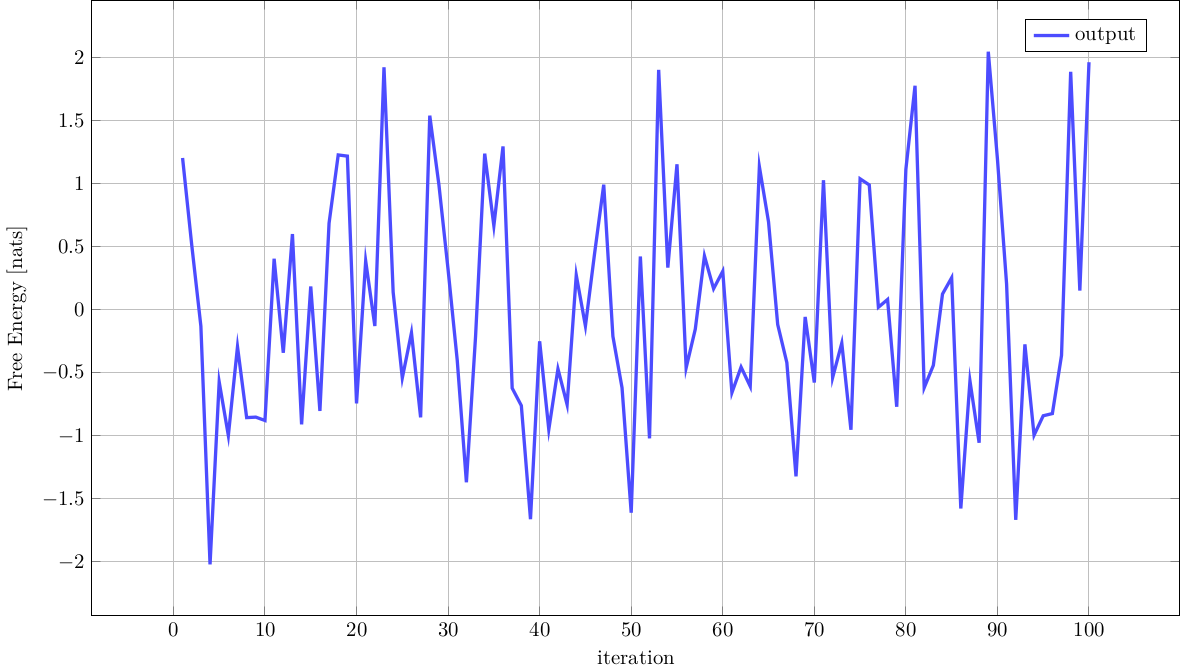

In [179]:
axis4 = @pgf Axis({xlabel="iteration",
                    ylabel="Free Energy [nats]",
                    legend_pos = "north east",
                    legend_cell_align="{left}",
                    scale = 1.0,
                    grid = "major",
                    width="20cm", height="12cm"
        },
    
    Plot({no_marks, color="blue!70", style={"ultra thick"}}, Coordinates(collect(1:length(output)), output)), LegendEntry("output"))